# Pandas vs SQL

While the size of the dataset for this exercise can easily fit in memory and all analysis code be done by simple pandas DataFrames, this notebook shows a different approach. One that's scalabale by doing the following:
1. Utilizing a SQL database to host the data and transform it as needed all using SQL.
2. Instead of reading the csv files from the zip file directly all at once, we're using an iterator that will read lines one at a time. thus we can read them in batches, send the batches to the SQL database, and move on to the next batch (this becomes relevant for when data is larger than available memory).
3. Using Indices on the database side to greatly improve data querying speed.

In [1]:
from pathlib import Path
from pprint import pprint
from sqlmodel import Session
from db_engine import DB_ENGINE
import matplotlib.pyplot as plt
import pandas as pd

# a helpful predefined function to read the csv files within a zip file line by line to save memory
from helper_funcs import create_record_iterator_from_csvs_in_zip_file

# a python Object that can be mapped to a SQL database table and its column (ORM using sqlmodel opensource library)
from sql_models import OrderRecord

# used to create the empty table defined above
from sql_models import recreate_db_tables_from_scratch

# used to read lines in batches, validate them according to the model defined above, and upload them to the SQL databae
from db_migration import migrate_records_to_db

# used to read a multi statement sql file into a python list of statements
from helper_funcs import read_sql_files

/tmp/ipykernel_18759/4175392196.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## checking data structure and creating needed table accordingly

In [7]:
zip_file_path = Path().parent / "dummy_order_data_6_months.zip"
iterator = create_record_iterator_from_csvs_in_zip_file(zip_file_path)
first_2_rows = [next(iterator) for i in range(2)]
pprint(first_2_rows)

[{'branch_uuid': 'dcecb4b3-35b9-49e5-b83f-9cb3c2231cad',
  'is_group_order': '0',
  'order_date': '2023-07-01',
  'order_uuid': '510bea1a-d467-4beb-ad6b-0ce3ecb5e303',
  'restaurant_uuid': 'a379b795-fd7a-4bd5-9c2e-70bcbba95533',
  'user_uuid': 'a6a67a63-c484-4f36-b1ab-672ba43149f2'},
 {'branch_uuid': '38453d7e-2224-11e8-924e-0242ac110011',
  'is_group_order': '0',
  'order_date': '2023-07-01',
  'order_uuid': '389aa01e-0074-4624-9092-0be598649969',
  'restaurant_uuid': '362334e4-2224-11e8-924e-0242ac110011',
  'user_uuid': 'dbd1ac1a-2039-4e4d-ac53-636b58dfd0aa'}]


In [3]:
recreate_db_tables_from_scratch()

## migrating the data from the CSV files to the SQL database in batches

In [4]:
migrate_records_to_db(zip_file_path, max_rows_to_migrate=1_000_000)

records parsed: 10000
adding 10000 to db
added 10000 to db, total rows inserted are 10000
records parsed: 20000
adding 10000 to db
added 10000 to db, total rows inserted are 20000
records parsed: 30000
adding 10000 to db
added 10000 to db, total rows inserted are 30000
records parsed: 40000
adding 10000 to db
added 10000 to db, total rows inserted are 40000
records parsed: 50000
adding 10000 to db
added 10000 to db, total rows inserted are 50000
records parsed: 60000
adding 10000 to db
added 10000 to db, total rows inserted are 60000
records parsed: 70000
adding 10000 to db
added 10000 to db, total rows inserted are 70000
records parsed: 80000
adding 10000 to db
added 10000 to db, total rows inserted are 80000
records parsed: 90000
adding 10000 to db
added 10000 to db, total rows inserted are 90000
records parsed: 100000
adding 10000 to db
added 10000 to db, total rows inserted are 100000
records parsed: 110000
adding 10000 to db
added 10000 to db, total rows inserted are 110000
record

# Overall user base retention rate

We will do the following using sql statements:
1. creation of a table that has distinct rows for (user_uuid, order_month) rows.
2. setting up indices on both columns to have faster joins and aggregations.
3. calculating the total active users each month.
4. calculating the total active users each month with activity in the previous month.
5. using these two values we can calculate the retention rate.

In [5]:
data_transformation_first_task_sql_fp = (
    Path().parent / "sql_queries" / "data_transformation_first_task.sql"
)
sql_stmts = read_sql_files(data_transformation_first_task_sql_fp)
with Session(DB_ENGINE) as session:
    for sql_stmt in sql_stmts:
        session.exec(sql_stmt)
    session.commit()

In [8]:
data_querying_first_task_fp = (
    Path().parent / "sql_queries" / "data_querying_first_task.sql"
)
sql_stmt = read_sql_files(data_querying_first_task_fp)[0]
df_retained_users = pd.read_sql((sql_stmt), DB_ENGINE)
df_retained_users

,year_month,total_month_active_users,retained_users_count,retained_precentage
0,202308,158838,84478,0.531850
1,202312,86092,32753,0.380442


<BarContainer object of 2 artists>

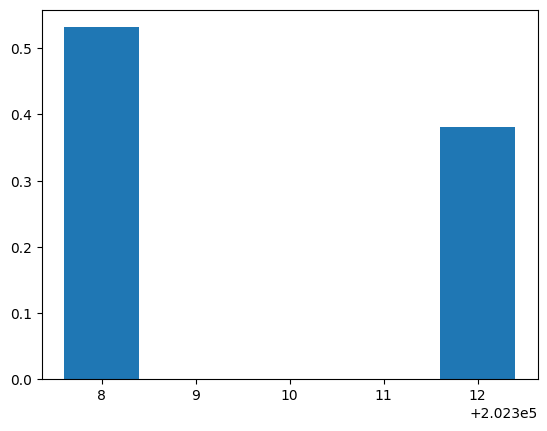

In [25]:
plt.bar(df_retained_users.year_month, df_retained_users.retained_precentage)

In [5]:
data_transformation_first_task_sql_fp = (
    Path().parent / "sql_queries" / "data_transformation_per_restaurant.sql"
)
sql_stmts = read_sql_files(data_transformation_first_task_sql_fp)
with Session(DB_ENGINE) as session:
    for sql_stmt in sql_stmts:
        session.exec(sql_stmt)
    session.commit()